* date: August 1, 2021
* author: nari
* This notebook contains code that uses the implemented BaseExplainer extensions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from grad import Gradient
from ebp import EBP
from integrated_gradients import IntegratedGradients
from guided_backprop import GuidedBackprop
from smoothgrad import SmoothGrad
from gradcam import GradCAM
from guided_gradcam import GuidedGradCAM
from lrp import LRP
from input_x_gradient import InputTimesGradient

from captum.attr import LayerAttribution

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import requests
import urllib.request

In [4]:
pytorch_model = models.vgg16(pretrained=True)
device = 'cpu'

Loads the sample images from the captum [CIFAR-10 tutorial](https://captum.ai/tutorials/CIFAR_TorchVision_Interpret).

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('models/cifar_torchvision.pt'))
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), 'models/cifar_torchvision.pt')

Using existing trained model


In [9]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

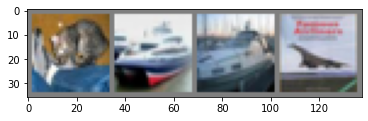

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [10]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [11]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [12]:
for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    break

In [13]:
# labels = labels.reshape(-1, 1)

In [14]:
sg = SmoothGrad(net)
sg_exp = sg.get_explanation(inputs, labels)
sg_exp.shape

torch.Size([4, 3, 32, 32])

In [15]:
gbp = GuidedBackprop(net)
gbp_exp = gbp.get_explanation(inputs, labels)
gbp_exp.shape

/Users/eshikasaxena/miniconda3/envs/xai/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/eshikasaxena/miniconda3/envs/xai/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:60: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


torch.Size([4, 3, 32, 32])

In [16]:
lrp = LRP(net)
lrp_exp = lrp.get_explanation(inputs, labels)
lrp_exp.shape

torch.Size([4, 3, 32, 32])

In [17]:
ebp = EBP(net)
ebp_exp = ebp.get_explanation(inputs, labels)
ebp_exp.shape

torch.Size([4, 1, 32, 32])

In [18]:
ig = IntegratedGradients(net)
ig_exp = ig.get_explanation(inputs, labels)
ig_exp.shape

torch.Size([4, 3, 32, 32])

In [19]:
gradcam = GradCAM(net, net.conv2)
gradcam_exp = gradcam.get_explanation(inputs, labels)
print(gradcam_exp.shape)
upsampled_attr = LayerAttribution.interpolate(gradcam_exp, (32, 32))
print(upsampled_attr.shape)

torch.Size([4, 1, 10, 10])
torch.Size([4, 1, 32, 32])


In [20]:
ggc = GuidedGradCAM(net, net.conv2)
ggc_exp = ggc.get_explanation(inputs, labels)
ggc_exp.shape

torch.Size([4, 3, 32, 32])

In [21]:
itg = InputTimesGradient(net)
itg_exp = itg.get_explanation(inputs, labels)
itg_exp.shape

torch.Size([4, 3, 32, 32])

In [22]:
grad = Gradient(net)
grad_exp = grad.get_explanation(inputs, labels)
grad_exp.shape

torch.Size([4, 3, 32, 32])

In [23]:
inputs.shape

torch.Size([4, 3, 32, 32])